# Práctico 3, SQL

In [38]:
import pyvo
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sp
import numpy as np
from IPython.display import display, Math, Latex

sintaxis SQL
select top 10 *  FROM (nombre tabla)
selecciona las primeras 10 entradas, el *  hace todas las columnas
select top 10 coadd_objectid,otracosa,otra_cosa  FROM  (nombre de tabla)
aca hace lo mismo, pero con algunas columnas

select coadd_objectid,otracosa,otra_cosa  FROM  (nombre de tabla)
aca me da todos pero algunas columnas.

matchear objetos de dos tablas con el ID:
SELECT t1.IDtabla1,t2.IDtabla2,t1.algo1,t1.algo2,t2.algo de esa tabla
From tabla1 AS t1
JOIN des_dr2.xqp5_main_sdss_dr17_specobi(es una tabla) AS t2 ON t1.IDtabla1=t2.IDtabla2
WHERE t1.ecliptic_lat <10 (filtro) AND ecliptic_t > -10 (puede ser AND OR  igual "=")

Para seleccionar random:
SELECT RANDOM TOP 10



## Introducción
Este informe se centra en el análisis estadístico de grandes conjuntos de datos observacionales utilizando bases de datos y el lenguaje SQL. Las bases de datos permiten almacenar grandes volúmenes de información de manera organizada, y con SQL, se pueden extraer y organizar subconjuntos de datos con características comunes en Tablas.
El objetivo de este trabajo es lograr una familiarización con el manejo de las bases de datos, pudiendo extraer información, procesar y analizar la misma con diferentes métodos y principios de probabilidad y estadística.

## Datos y análisis

En mi caso, voy a utilizar una base de datos de exoplanetas(exoplanets.eu). Para esto nos vamos a conectar a un servidor utilizando la tarea pyvo, y vamos a descargar los datos que querramos usando lenguaje SQL.

In [2]:
service = pyvo.dal.TAPService("http://voparis-tap-planeto.obspm.fr/tap")#me conecto al servidor

In [3]:
query = """SELECT obs_id,granule_uid,mass,period,semi_major_axis,  
            star_age,detection_type,radius FROM exoplanet.epn_core 
            WHERE mass < 13"""   #Extraigo los campos de la tabla que voy a utilizar en este trabajo, y tambien filtro en masa,
                                #para considerar planetas y no enanas marrones

In [4]:
results = service.search(query) 

In [5]:
results.table[:3] #visualizo como queda mi tabla

obs_id,granule_uid,mass,period,semi_major_axis,star_age,detection_type,radius
,,jupiterMass,d,AU,Gyr,,jupiterRad
object,object,float64,float64,float64,float64,object,float64
95,109 Psc b,5.743,1075.4,2.051,6.9,Radial Velocity#Astrometry,1.152
9287,112 Psc b,0.033,4.4,0.054,--,Radial Velocity,--
9288,112 Psc c,9.866,36336.7,22.21,--,Radial Velocity#Astrometry,--


In [6]:
len(results)

3113

In [7]:
len(results[0])

8

In [8]:
table = results.to_table() 

In [9]:
df = table.to_pandas() 

In [10]:
df.set_index('granule_uid',inplace = True) #estoy reemplazando el indice por el nombre del planeta
df 

,obs_id,mass,period,semi_major_axis,star_age,detection_type,radius
granule_uid,,,,,,,
109 Psc b,95,5.74300,1075.40000,2.05100,6.90,Radial Velocity#Astrometry,1.152
112 Psc b,9287,0.03300,4.40000,0.05400,NaN,Radial Velocity,NaN
112 Psc c,9288,9.86600,36336.70000,22.21000,NaN,Radial Velocity#Astrometry,NaN
11 UMi b,575,11.08730,516.22000,1.54000,1.56,Radial Velocity,NaN
14 And Ab,489,4.68400,185.84000,0.83000,NaN,Radial Velocity,NaN
...,...,...,...,...,...,...,...
YBP401 b,3966,0.46000,4.08700,NaN,4.00,Radial Velocity,NaN
YSES 2 b,7830,6.30000,NaN,114.00000,13.90,Imaging,NaN
YZ Cet b,6603,0.00220,2.02087,0.01634,4.00,Radial Velocity,NaN


In [11]:
df.to_csv('datos.csv') #aca guardamos la tabla

In [12]:
RV = df.loc[:, 'detection_type'] == 'Radial Velocity' # creo diferentes dataframes, separando por metodo de detección
df_RV = df.loc[RV]
TRAN = df.loc[:, 'detection_type'] == 'Primary Transit'
df_TRAN = df.loc[TRAN]
IMA = df.loc[:, 'detection_type'] == 'Imaging'
df_IMA = df.loc[IMA]
Astrom = df.loc[:, 'detection_type'] == 'Astrometry'
df_Astrom = df.loc[Astrom]
ML = df.loc[:, 'detection_type'] == 'Microlensing'
df_ML = df.loc[ML]
Pulsar= df.loc[:, 'detection_type'] == 'Pulsar'
df_Pulsar = df.loc[Pulsar]
TTV = df.loc[:, 'detection_type'] == 'TTV'
df_TTV = df.loc[TTV]
Other = df.loc[:, 'detection_type'] == 'Other'
df_Other = df.loc[Other]

### Análisis de sesgo observacional
En esta sección queremos explorar si las tecnicas observacionales estan sesgadas, ya sea por una caracterisca intriseca del planeta o por su relacion con su estrella.

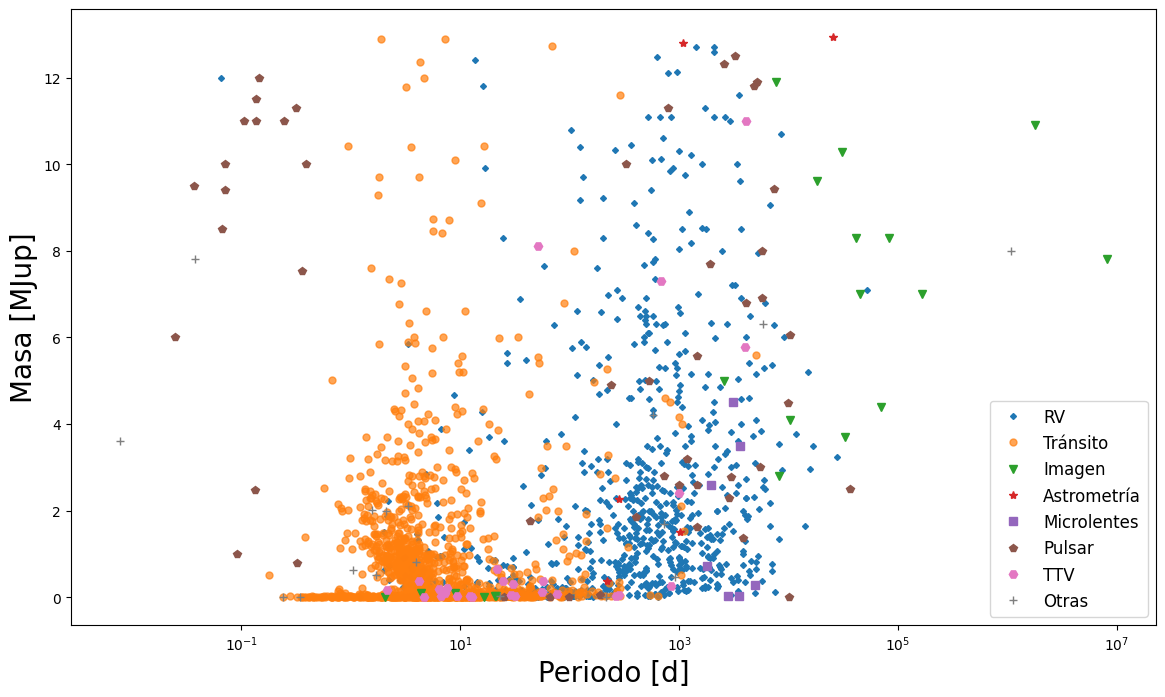

In [13]:
plt.figure(figsize=(14, 8))
plt.plot(df_RV['period'], df_RV['mass'], 'D', label='RV', ms=3)
plt.plot(df_TRAN['period'], df_TRAN['mass'], 'o', label='Tránsito', alpha=0.7, ms=5)
plt.plot(df_IMA['period'], df_IMA['mass'], 'v', label='Imagen')
plt.plot(df_Astrom['period'], df_Astrom['mass'], '*', label='Astrometría')
plt.plot(df_ML['period'], df_ML['mass'], 's', label='Microlentes')
plt.plot(df_Pulsar['period'], df_Pulsar['mass'], 'p', label='Pulsar')
plt.plot(df_TTV['period'], df_TTV['mass'], 'H', label='TTV')
plt.plot(df_Other['period'], df_Other['mass'], '+', label='Otras')

plt.xscale('log')
plt.xlabel('Periodo [d]', fontsize=20)
plt.ylabel('Masa [MJup]', fontsize=20)
plt.legend(fontsize=12, loc='best')
plt.show()

El sesgo es claro en funcion del periodo orbital, se pueden obeservar dos grandes aglomeraciones para las tecnicas de "tránsito" y "velocidad radial". Aunque tambien parece que la tecnica de tránsito tiene muchas mas detecciones de planetas menos masivos(M >2 Mjup).

Ahora vamos a analizar por separado a la masa y periodos orbitales en función de la tecnica utilizada.

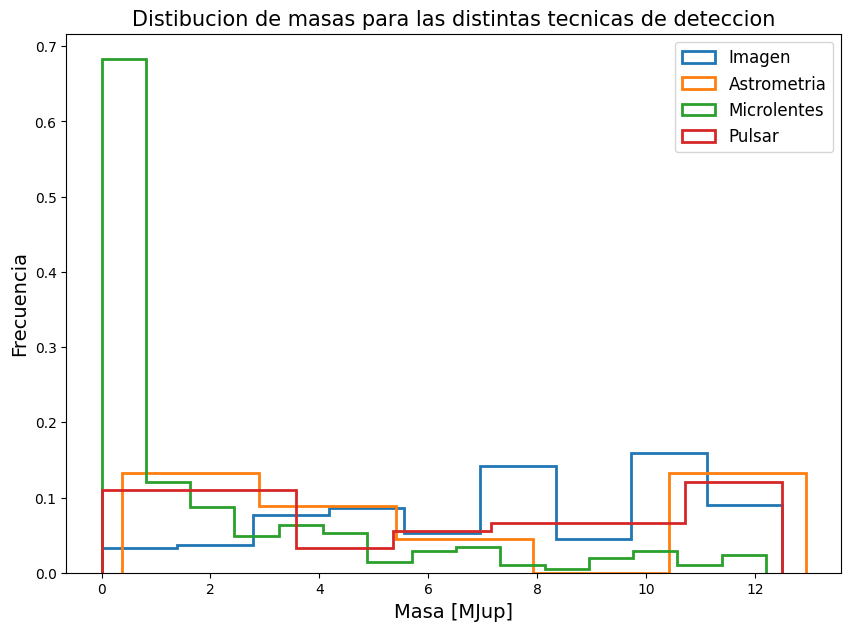

In [14]:
plt.figure(figsize=(10, 7))
plt.hist(df_IMA['mass'],bins = 'auto',density = True,histtype ='step', label = 'Imagen',lw =2)
plt.hist(df_Astrom['mass'],bins = 'auto',density = True,histtype ='step', label = 'Astrometria',lw = 2)
plt.hist(df_ML['mass'],bins = 'auto',density = True,histtype ='step', label = 'Microlentes', lw = 2)
plt.hist(df_Pulsar['mass'],bins = 'auto',density = True,histtype ='step', label = 'Pulsar', lw = 2)
plt.legend(fontsize=12, loc='best')
plt.title('Distibucion de masas para las distintas tecnicas de deteccion', fontsize=15)
plt.xlabel('Masa [MJup]', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()
#los separo en dos graficos porque se encimaban mucho

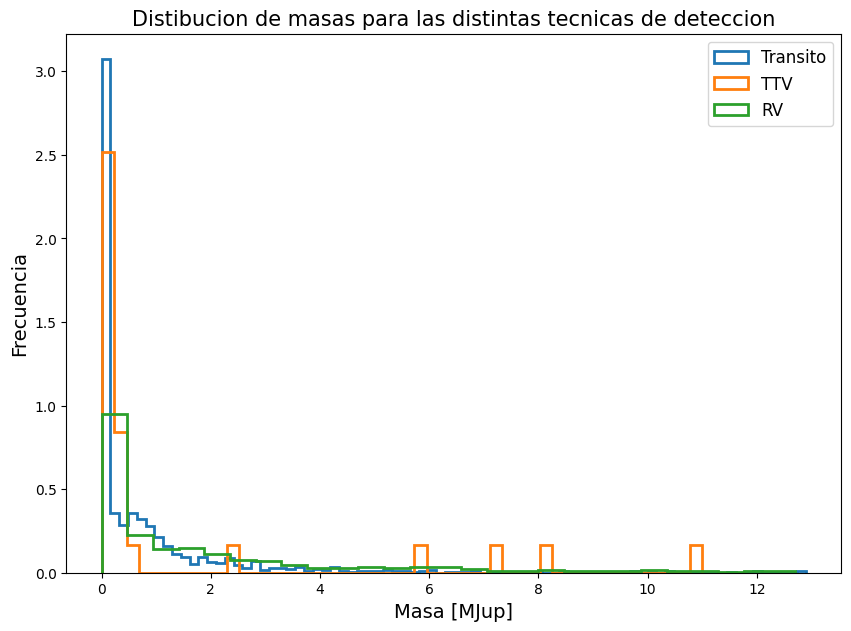

In [37]:
plt.figure(figsize=(10, 7))
plt.hist(df_TRAN['mass'],bins = 'auto',density = True,histtype ='step', label = 'Transito',lw = 2)
plt.hist(df_TTV['mass'],bins = 'auto',density = True,histtype ='step', label = 'TTV',lw = 2)
plt.hist(df_RV['mass'],bins = 'auto',density = True,histtype ='step', label = 'RV',lw = 2)
plt.legend(fontsize=12, loc='best')
plt.title('Distibucion de masas para las distintas tecnicas de deteccion', fontsize=15)
plt.xlabel('Masa [MJup]', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

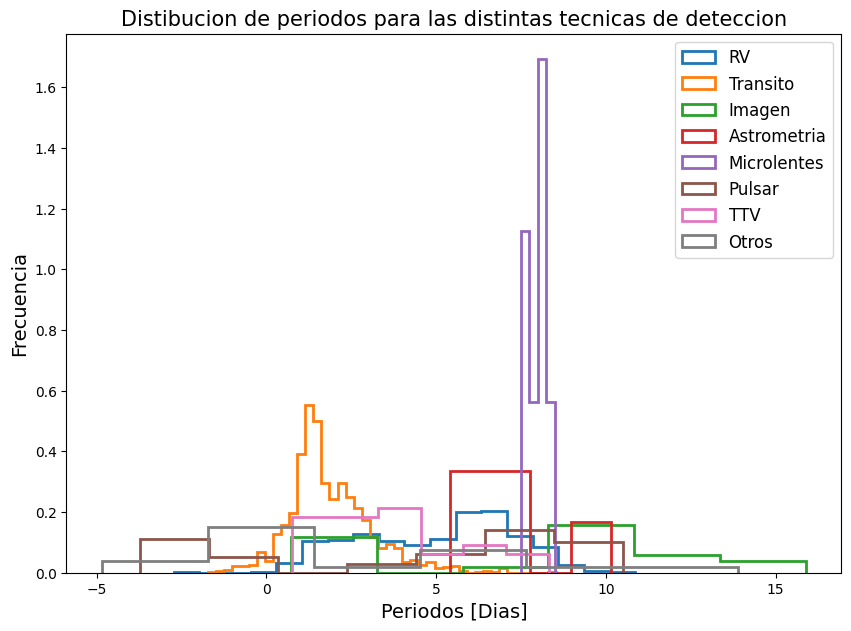

In [16]:
plt.figure(figsize=(10, 7))
plt.hist(np.log(df_RV['period']),bins = 'auto',density = True,histtype ='step', label = 'RV',lw = 2)
plt.hist(np.log(df_TRAN['period']),bins = 'auto',density = True,histtype ='step', label = 'Transito',lw = 2)
plt.hist(np.log(df_IMA['period']),bins = 'auto',density = True,histtype ='step', label = 'Imagen',lw =2)
plt.hist(np.log(df_Astrom['period']),bins = 'auto',density = True,histtype ='step', label = 'Astrometria',lw = 2)
plt.hist(np.log(df_ML['period']),bins = 'auto',density = True,histtype ='step', label = 'Microlentes', lw = 2)
plt.hist(np.log(df_Pulsar['period']),bins = 'auto',density = True,histtype ='step', label = 'Pulsar', lw = 2)
plt.hist(np.log(df_TTV['period']),bins = 'auto',density = True,histtype ='step', label = 'TTV',lw = 2)
plt.hist(np.log(df_Other['period']),bins = 'auto',density = True,histtype ='step',label = 'Otros',lw = 2)
plt.legend(fontsize=12, loc='best')
plt.title('Distibucion de periodos para las distintas tecnicas de deteccion', fontsize=15)
plt.xlabel('Periodos [Dias]', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

En los ultimos 3 gráficos, se observa que todas las técnicas presentan sesgos en diferentes rangos de masa y período. Si no fuera así, se esperaría una distribución similar tanto en las masas como en los períodos para todas las técnicas de observación.

## Distancia a la estrella.
Ahora vamos a estudiar la distriución de semieje mayor de los planetas y queremos ver si esta distribución es consistente con una distribución gaussiana.

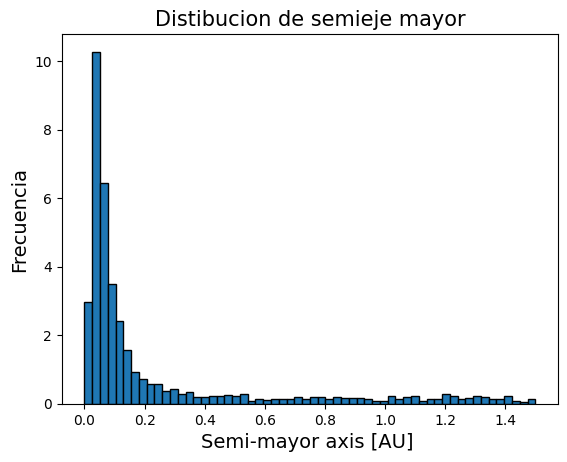

In [17]:
plt.hist(df['semi_major_axis'],bins = 'auto',edgecolor = 'black',range=[0,1.5],density = True)
plt.title('Distibucion de semieje mayor', fontsize=15)
plt.xlabel('Semi-mayor axis [AU] ', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()
plt.show()

Para ver si esta distribucion es consistente con una distribucion gaussiansa vamos a usar el test KS. Obtendremos el p-value y verificaremos si es mayor que un nivel de significancia determinado. Si es así, no podríamos rechazar la hipótesis nula de que esta distribución es consistente con una distribución gaussiana.

In [18]:
au = df['semi_major_axis'][(df['semi_major_axis']>0) & (df['semi_major_axis']<=1.5)]

In [19]:
sp.kstest(au,'norm')

KstestResult(statistic=0.5003327178232841, pvalue=0.0, statistic_location=0.000834, statistic_sign=-1)

Vemos que no importa el nivel de significancia que tomemos, el valor de p va a ser menor. Por lo tanto, se rechaza la hipostesis nula.

## Masa vs Radio
En esta sección vamos a ver que existe una relación entre masa y radio, y vamos a proponer un modelo para esta relación y vamos a realizar un ajuste de los datos.

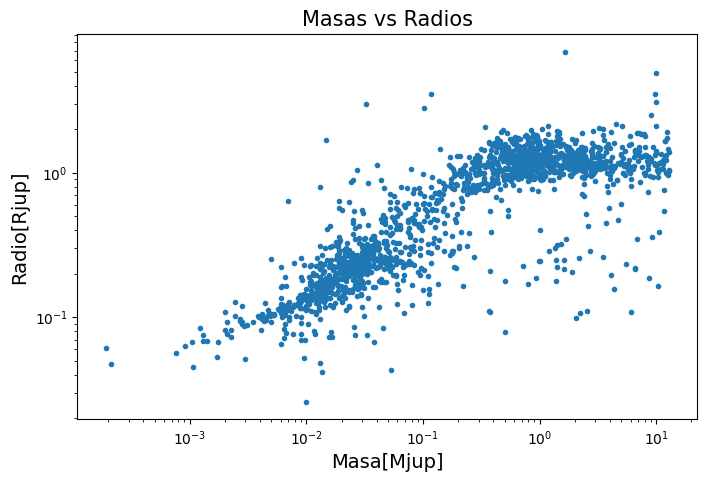

In [20]:
plt.figure(figsize=(8, 5))
plt.plot(df['mass'],df['radius'],'o',ms=3)
plt.xscale('log')
plt.yscale('log')
plt.title('Masas vs Radios',fontsize=15)
plt.xlabel("Masa[Mjup]",fontsize=14);plt.ylabel("Radio[Rjup]",fontsize=14)
plt.show()

A partir del gráfico, observamos que es posible realizar un ajuste lineal a los datos utilizando la función polyfit, con la cual obtendremos los parámetros del ajuste. Para ello, primero igualaremos la longitud de las tablas, combinándolas previamente y eliminando los valores que contienen NaN, asegurándonos así de evitar errores en el proceso de ajuste.

In [21]:
x = df['mass'][~df['mass'].isna()]
y = df['radius'][~df['radius'].isna()]
df_ = pd.merge(left = x,right= y,how ='inner',on ='granule_uid')
df_.head()

,mass,radius
granule_uid,,
109 Psc b,5.743,1.152
2MASS J0030-1450,10.000,1.360
2MASS J0141-4633,1.380,1.011
2MASS J0323-4631,1.570,0.976
2MASS J0437+2331,7.100,1.890


In [22]:
fit = np.polyfit(np.log(df_['mass']),np.log(df_['radius']),1) #Ahora fit me guarda los parametros del ajuste
fit

array([ 0.36462692, -0.07508749])

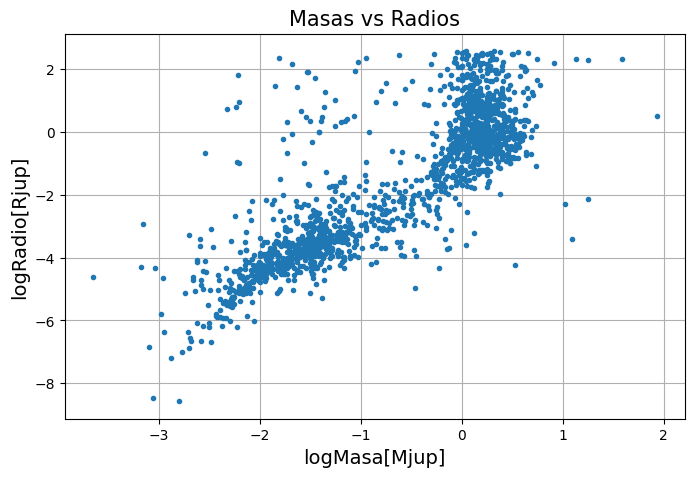

In [41]:
plt.figure(figsize=(8, 5))
#plt.plot(np.log(df['mass']),np.log(df['radius']),'o',ms=3)
plt.plot(np.log(df['radius']),np.log(df['mass']),'o',ms=3)
plt.title('Masas vs Radios',fontsize=15)
plt.xlabel("logMasa[Mjup]",fontsize=14);plt.ylabel("logRadio[Rjup]",fontsize=14)
#t = np.linspace(-9,3,50)
#plt.plot(t, fit[0]*t+fit[1],color = 'r')
plt.grid()

Con lo que despejando los logaritmos llegamos a la siguiente expresión:

La relación es:

$$ R = c \cdot M^a $$ 

Con:

$$ c = 10^b = 0.84 $$

y 

$$ a = 0.37 $$

Por lo tanto:

$$ R \sim M^3 $$



## Masa vs edad
Por ultimo vamos a analizar si existe una relación con la edad de la estrella.

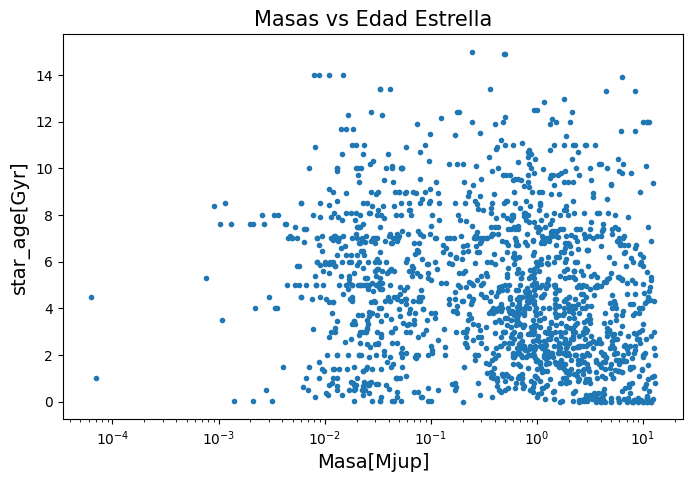

In [33]:
plt.figure(figsize=(8, 5))
plt.plot(df['mass'],df['star_age'],'o',ms=3)
plt.xscale('log')
#plt.yscale('log')
plt.title('Masas vs Edad Estrella',fontsize=15)
plt.xlabel("Masa[Mjup]",fontsize=14);plt.ylabel("star_age[Gyr]",fontsize=14)
plt.show()

Podemos ver que la distribucion es una nube de puntos por lo que no se observa ninguna tendencia. Aunque si podemos observar un sesgo por los planetas mas masivos, que en general las tecnicas de deteccion son mas sensibles a estos.

# Conclusiones

El uso de SQL junto con la biblioteca Pandas facilita tanto la obtención como la manipulación de datos de forma simple y práctica, permitiendo analizarlos y extraer, como vimos en el ejercicio de Masa vs Radio, modelos que relacionen distintas características o parámetros de los objetos en estudio.

Respecto al analicis realizado con la base del exoplanets, podemos decir que:

1_ Todas las tecnicas observacionales tienen un sesgo, ya sea en la Masa o en el Periodo del planeta.
2_ La distribución de semieje mayor de los planetas no sigue una distribucion Gaussiana.
3_ Existe una relación de la Masa con Radio que siguen una ley de potencias




